## Resume Parser using NLP(Spacy) and Machine Learning

### What is Resume Parsing?
<i>Resume parsing is a technology used in the field of Human Resources and recruitment to extract relevant information from job applicants' resumes or CVs (Curriculum Vitae). The goal of resume parsing is to automate the process of collecting and categorizing data, making it easier for employers and HR professionals to review and compare the qualifications of candidates</i>

### Spacy
<i> spaCy is an open-source software library for advanced natural language processing, written in the programming languages Python and Cython. spaCy comes with pretrained pipelines and currently supports tokenization and training for 60+ languages

## Importing necessary modules

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import random

## Data Preprocessing

### 1.  Analysing Resume dataset

In [2]:
df = pd.read_csv("resume_data.csv") #a dataset containing many resume's content
df.head()

,Name,Email,Company,Start Date,End Date,Skill,Language
0,William Sheppard,kdorsey@example.org,Gates-Bates,1977-02-12,2003-03-03,HTML,English
1,Timothy Goodwin,elizabethchandler@example.org,"Blevins, Graham and Sweeney",1970-02-18,2008-04-03,JavaScript,Spanish
2,Rebecca Ward,sarah17@example.org,Green-Jones,1984-11-23,2006-11-30,Node.js,English
3,Joshua Jensen,paullee@example.org,Carter Group,1989-02-01,2017-03-05,HTML,German
4,Alicia Howell MD,dorothychavez@example.com,Blevins-Harris,1991-02-08,2023-01-08,Angular,English


### 1.1 EDA of Resume dataset

Lets do analysis on the company these people have worked.

In [3]:
df['Company'].value_counts()

Smith Group               18
Smith PLC                 14
Williams Group            12
Johnson and Sons          12
Smith Inc                 12
                          ..
Christian PLC              1
Olsen-Allen                1
Washington-Palmer          1
Logan, Wolf and Martin     1
Salinas-Wilson             1
Name: Company, Length: 8667, dtype: int64

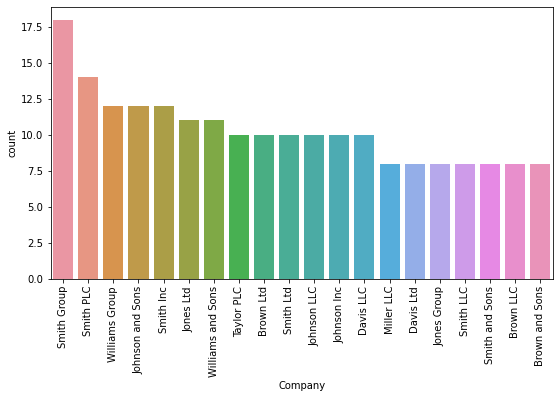

In [4]:
plt.figure(figsize=(9,5))
sns.countplot(x='Company', data=df, order=pd.value_counts(df['Company']).iloc[:20].index)
plt.xticks(rotation=90)
plt.show()

In [5]:
df['Company'].unique()

array(['Gates-Bates', 'Blevins, Graham and Sweeney', 'Green-Jones', ...,
       'Yoder-Hatfield', 'Castillo PLC', 'Salinas-Wilson'], dtype=object)

In [6]:
print(f"No of Unique Companies: {df['Company'].unique().shape[0]}")

No of Unique Companies: 8667


### 2. Parsing through individual resumes

### 2.1 Converting individual pdf resume to text format

Here we extracted the text from resume using PyPDF2 and stored it in 'output.txt' file.

In [7]:
import PyPDF2 #Function for converting pdf to plaintext

# Opening the PDF file
with open('Student.pdf', 'rb') as pdf_file:
    # Create a PDF reader object
    pdf_reader = PyPDF2.PdfReader(pdf_file)

    # Initializing an empty string to store the extracted text
    resume_text = ''

    # Looping through each page and extracting the text
    for num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[num]
        resume_text += page.extract_text()


# You can also save the text to a file if needed


sw_nltk = stopwords.words('english')
words = [word for word in resume_text.split() if word.lower() not in sw_nltk]
new_text1 = " ".join(words)

with open('output.txt', 'w', encoding='utf-8') as text_file:
    text_file.write(new_text1)

new_text1

"Name First.lastname@selu.edu • 985-555-1234 • City, State Zip Code EDUCA TION Southeastern Louisiana University , Hammond, LA Bachelor Science, Biological Sciences , GPA: 3.1, May 2025 WORK EXPERIENCE Dining Room Attendant , August 2020 –March 2021 SLU Food Services, Hammond, LA ● Maintained clean safe environment dining hall serving 1,000+ patrons daily ● Communicated students staff resolve issues ensure quality experience ● Completed Student Manager Training Program within first month work Babysitter , August 2019 – June 2020 Self-Employed , Covington, LA ● Ensured safety , health, welfare 2 children, ages 3 8, every day school ● Organized safe, fun, educational activities visits park crafts ● Supported learning explaining homework working problems together LEADERSHIP EXPERIENCE Student Athlete, Role/Position, August 2020 – Present Volleyball Team, Southeastern Louisiana University ● Selected 1 # team members completing 20-hour intensive training period ● Participated # philanthropy

### 2.2 Sample resume text
Here we use resume text from the txt format itself (which is equivalent to reading a resume in text format).

In [8]:
text_file = '''John Clark
Data Scientist

Summary:
Experienced data scientist with a background in machine learning and natural language processing.

Skills:
- Machine Learning
- NLP
- Python
- Data Analysis
- Deep Learning

Contact:
+91 9425372877

Email:
johnclark132@gmail.com

Education:
- M.S. in Computer Science, University of XYZ
- B.S. in Mathematics, University of ABC

Work Experience:
Data Scientist, Company Google
- Developed machine learning models for customer churn prediction.
- Analyzed and processed text data using NLP techniques.

Software Engineer, Company Microsoft
- Worked on software development projects using Python and Java.    '''


sw_nltk = stopwords.words('english')
words = [word for word in text_file.split() if word.lower() not in sw_nltk]
new_text = " ".join(words)

new_text

'John Clark Data Scientist Summary: Experienced data scientist background machine learning natural language processing. Skills: - Machine Learning - NLP - Python - Data Analysis - Deep Learning Contact: +91 9425372877 Email: johnclark132@gmail.com Education: - M.S. Computer Science, University XYZ - B.S. Mathematics, University ABC Work Experience: Data Scientist, Company Google - Developed machine learning models customer churn prediction. - Analyzed processed text data using NLP techniques. Software Engineer, Company Microsoft - Worked software development projects using Python Java.'

## 3. NLP Model Development

In [9]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Loading the English language model from spaCy
nlp = spacy.load("en_core_web_sm")

### 3.1 Extracting skills using Word Embedding

<b>Word Embedding or Word Vector </b> is a numeric vector input that represents a word in a lower-dimensional space. It allows words with similar meanings to have a similar representation. They can also approximate meaning. A word vector with 50 values can represent 50 unique features.

In [11]:
skills_needed_for_job = ["Python", "Java", "Machine Learning", "Data Analysis", "Teamwork", 'C++', "NLP", "Javascript"]

def skills(resume_text, skills_needed_for_job): #defining the function
    skill_vectors = {} #a dictionary is initialized to store the cosine similarity scores for each skill
    
    for skill in skills_needed_for_job: 
        skill_vec = nlp(skill).vector #using nlp to obtain vector representation of that skill while iterating through the loop.
        resume_vec = nlp(new_text).vector #same but for new_text i.e.cleaned resume text
        
        # Calculating the cosine similarity between the skill vector and resume vector:
        similarity = np.dot(skill_vec, resume_vec) / (np.linalg.norm(skill_vec) * np.linalg.norm(resume_vec))
        
        if similarity > 0.6:  # Deciding a threshold to check relevant skills
            skill_vectors[skill] = similarity #added to skill vectors if above threshold
    
    # Sorting skills by similarity score
    extracted_skills = sorted(skill_vectors, key=skill_vectors.get, reverse=True)
    
    return extracted_skills

skills(text_file, skills_needed_for_job)

['Machine Learning', 'Data Analysis']

### 3.2 Extracting Education using Regex

Regular expressions (regex) are patterns used for matching and manipulating strings. They are powerful tools for text processing and searching.

In [12]:
import re 
def extract_education(new_text):
    education = []
    pattern = r"(?:B\.Sc\. |B\.S\.|M\.Sc\.|M\.S\.|Ph\.D\.|B\.Tech\.|M\.Tech\.|B\.A\.|M\.A\.|B\.E\.|M\.E\.|B\.Com\.|M\.Com\.)"
    matches = re.findall(pattern, new_text)
    for match in matches:
        education.append(match.strip())

    return education


education_details = extract_education(new_text)
if education_details:
    print("Education Details:")
    for edu in education_details:
        print(edu)
else:
    print("No education details found.")

Education Details:
M.S.
B.S.


### 3.3 Extracting Name using regex

In [13]:
def extract_name(text):
    name = []

    # Using regex pattern a name
    patterns = r"(\b[A-Z][a-z]+\b)\s(\b[A-Z][a-z]+\b)"
    match = re.search(patterns, text) #
    if match:
        name = match.group()

    return name

    

name = extract_name(new_text)

if name:
    print("Name:", name)
else:
    print("Name not found")

Name: John Clark


### 3.4 Extracting Contact using regex

In [14]:
def extract_contact(text):
    contact = []
    
    patterns1 = r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]'

    match = re.search(patterns1, text)
    if match:
        contact = match.group()
    return contact


contact = extract_contact(new_text)
if contact:
    print("Contact:", contact)
else:
    print("Contact Number not found")

Contact: +91 9425372877


### 3.5 Extracting Email using regex

In [15]:
def extract_email(text):
    email = []
    
    patterns2 = r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+'

    match = re.search(patterns2, text)
    if match:
        email = match.group()
    return email


email = extract_email(new_text)
if email:
    print("Email:", email)
else:
    print("Email not found")

Email: johnclark132@gmail.com
